In [221]:
import numpy as np
import matplotlib.pyplot as plt
import os
from math import sqrt, log
from typing import Callable

### Input parsing and cleaning

The first task of the assignment is to parse the input, and get rid of the data points with missing or malformed features.

In our case, we decided to parse the CSV files manually.

We start by implementing a function which, given a line of data, tells us whether the line is clean or malformed.

In [222]:
def is_clean(line: str) -> bool:
    for data_entry in line.split(","):
        if data_entry == "?":
            return False
    
    return True

Next, we proceed to read the file line-by-line, check for cleanliness, and finally parse the resulting input list to a numpy array of floats.

In [223]:
# Import hepatitis data
__hepatitis_data = open(os.path.abspath('') + "/data/hepatitis.data")

hepatitis_clean_data: list[str] = []

for __line in __hepatitis_data.readlines():
    __line = __line.strip('\n')
    if(is_clean(__line)):
        hepatitis_clean_data.append(__line.split(','))

hepatitis_clean_data: np.ndarray = np.array(hepatitis_clean_data, float)

__hepatitis_data.close()



# Import diabetes data
__diabetes_data = open(os.path.abspath('') + "/data/messidor_features.arff")

diabetes_clean_data: list[str] = []

__read: bool = False
for __line in __diabetes_data.readlines():
    __line = __line.strip('\n')
    if __read and is_clean(__line):
        diabetes_clean_data.append(__line.split(','))

    else:
        __read = __line == "@data"

diabetes_clean_data: np.ndarray = np.array(diabetes_clean_data, float)
diabetes_clean_data[:, [-1, 0]] = diabetes_clean_data[:, [0, -1]] # Place class in first column
diabetes_clean_data = diabetes_clean_data[:, :-1]

__diabetes_data.close()

We also hardcode the feature names.

In [224]:
hepatitis_feature_names: list[str] = ['Alive', 'Age', 'Sex', 'Steroid', 'Antivirals', 'Fatigue', 'Malaise', 'Anorexia', 'Liver Big', 'Liver Firm', 'Spleen Palpable', 'Spiders', 'Ascites', 'Varices', 'Bilirubin', 'Alk Phosphate', 'Sgot', 'Albumin', 'Protime', 'Histology']
diabetes_feature_names: list[str] = ['Has DR', 'Assesment Quality', 'Retinal Abnormality Pre-screening', 'MA (alpha=0.5)', 'MA (alpha=0.6)', 'MA (alpha=0.7)', 'MA (alpha=0.8)', 'MA (alpha=0.9)', 'MA (alpha=1.0)', 'exudates (alpha=0.3)', 'exudates (alpha=0.4)', 'exudates (alpha=0.5)', 'exudates (alpha=0.6)', 'exudates (alpha=0.7)', 'exudates (alpha=0.8)', 'exudates (alpha=0.9)', 'exudates (alpha=1.0)', 'Macula-Optic Disc Distance', 'Optic Disc Diameter', 'AM/FM Based classification']

Now that we have our inputs, we proceed to shuffle the data and divide into training, test, and validation sets.

We choose the following split: 50% training, 25% testing, 25% validation.

In [225]:
hepatitis_training = []
hepatitis_testing = []
hepatitis_validation = []

diabetes_training = []
diabetes_testing = []
diabetes_validation = []

hepatitis_size = hepatitis_clean_data.shape[0]
hepatitis_size_50 = int(hepatitis_size / 2)
hepatitis_size_75 = int(hepatitis_size * 3 / 4)

diabetes_size = diabetes_clean_data.shape[0]
diabetes_size_50 = int(diabetes_size / 2)
diabetes_size_75 = int(diabetes_size * 3 / 4)

def shuffle():
    global hepatitis_training
    global hepatitis_testing
    global hepatitis_validation
    global diabetes_training
    global diabetes_testing
    global diabetes_validation

    # Shuffle and split hepatitis data
    np.random.shuffle(hepatitis_clean_data)
    hepatitis_training = hepatitis_clean_data[:hepatitis_size_50]
    hepatitis_testing = hepatitis_clean_data[(hepatitis_size_50 + 1):hepatitis_size_75:1]
    hepatitis_validation = hepatitis_clean_data[(hepatitis_size_75 + 1):]


    # Shuffle and split diabetes data
    np.random.shuffle(diabetes_clean_data)
    diabetes_training = diabetes_clean_data[:diabetes_size_50]
    diabetes_testing = diabetes_clean_data[(diabetes_size_50 + 1):diabetes_size_75:1]
    diabetes_validation = diabetes_clean_data[(diabetes_size_75 + 1):]

shuffle()

### Models implementation

Next up, we want to build both of our models (KNN and DT) as classes.

For our experiment we want our models to have at least a fitting and predicting functionality.
Therefore, we start by defining a base Model class.

In [226]:
class Model:
    
    def __init__(self, hyperparameter: int):
        pass
    
    def fit(self, training_data, true_labels) -> "Model":
        pass
    
    def predict(self, input) -> list:
        pass

#### Helper methods

However, before we can proceed to implement these, we need to implement some helper functions which will be of use in the classes.

In [227]:
def euclidean_distance(x1: list[float], x2: list[float]) -> float:
    return np.sqrt(np.sum((np.array(x2) - np.array(x1)) ** 2))


def manhattan_distance(x1: list[float], x2: list[float]) -> float:
    return np.sum(np.absolute(np.array(x1) - np.array(x2)))


def most_common_label(l: list):
    return np.bincount(np.array(l, int)).argmax()


def evaluate_acc(true_labels: list, target_labels: list) -> float:
    return np.sum(true_labels == target_labels) / len(true_labels)


def gini_index(labels):
    class_probs = np.bincount(labels.astype(int)) / len(labels)
    return 1 - np.sum(class_probs ** 2)


def misclass_rate(labels):
    return np.sum(labels != np.array([most_common_label(labels)] * len(labels)))/len(labels)


def entropy(labels):
    c_probs = np.bincount(labels.astype(int))/len(labels)
    s = 0
    for c in c_probs:
        if (c != 0): 
            s -= c * log(c,2)
    return s
    

def cosine_similarity(vector1,vector2):
    return np.sum(vector1 * vector2)/(sqrt(np.sum(vector1 ** 2)) * sqrt(np.sum(vector2 ** 2)))


def features_by_relevance(data: np.ndarray, true_labels: np.ndarray) -> np.ndarray:
    similarities = []
    for i in range(data.shape[1]):
        similarities.append(cosine_similarity(data[:,i],true_labels))
    return np.array(similarities)


def remove_irrelevant_features(data : np.ndarray, true_labels : np.ndarray, nb_features : int) -> np.ndarray:
    # similarities = np.apply_along_axis(lambda d: cosine_similarity(d, true_labels), 0, data)
    similarities = features_by_relevance(data, true_labels)
    min_similarities = np.argpartition(similarities,nb_features)
    return np.delete(data, min_similarities[:nb_features], 1)

#### KNN Graph implementation

We now proceed to implement our KNN Graph class which is a subclass of Model.

In [228]:
class KNN_Graph(Model):

    k: int
    dist_fn: Callable[[list[float], list[float]], float]
    training_data: np.ndarray
    true_labels: list[str]

    def __init__(self, k: int = 1, dist_fn: Callable[[list[float], list[float]], float] = euclidean_distance):
        self.distances_valid = False
        self.k = k
        self.dist_fn = dist_fn


    def fit(self, training_data: np.ndarray, true_labels: list[str]) -> "KNN_Graph":
        self.distances_valid = False
        self.training_data = training_data
        self.true_labels = true_labels
        return self
    

    def compute_distances_single_point(self, test_data_point):
        distances = np.apply_along_axis(lambda tdp: [self.dist_fn(test_data_point, tdp[1:]), tdp[0]], 1, self.training_data)
        distances = distances[distances[:, 0].argsort()] # Sort based row by first column
        return distances


    def compute_distances(self, test_data) -> np.ndarray:
        return np.apply_along_axis(self.compute_distances_single_point, 1, test_data)
    

    def predict(self, test_data: np.ndarray) -> list:
        distances = self.compute_distances(test_data)
        return [most_common_label(d[:self.k, 1]) for d in distances]
    

    def k_trial(self, validation_data, validation_labels, max_k: int) -> np.ndarray:
        distances = self.compute_distances(validation_data)

        accuracies = []
        for k in range(1, max_k):
            self.k = k
            predictions = [most_common_label(d[:k, 1]) for d in distances]
            accuracies.append(evaluate_acc(validation_labels,predictions))

        return np.array(accuracies)
        

    def validate_k(self, validation_data, validation_labels, max_k) -> "KNN_Graph":
        accuracies = self.k_trial(validation_data, validation_labels, max_k)
        self.k = np.argmax(accuracies) + 1
        return self


#### Decision tree implementation

Next, we implement our DT class which is also a subclass of Model.
However, this model also requires a Node class which we implement too.

In [229]:
class Node:

    depth: int
    feature : int
    threshold : float
    
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1
            self.data = parent.data
            self.labels = parent.labels   

                   

class DecisionTree(Model):

    max_depth: int
    root: Node
    cost_fn: Callable[[list[float]], float]
    def __init__(self, max_depth: int = 1, cost_fn: Callable[[list[float]], float] = gini_index):
        self.max_depth = max_depth
        self.cost_fn = cost_fn
        self.root = None


    def greedy_split(self, node):
        best_feature, best_threshold = None, None
        best_cost = np.inf
        nb_points, nb_features = node.data.shape
        sorted_data = np.sort(node.data[node.data_indices], axis=0)
        thresholds = test_candidates = (sorted_data[1:] + sorted_data[:-1]) / 2.
        for i in range(nb_features):
            feature_data = node.data[node.data_indices, i]
            for t in thresholds[:,i]:
                left_indices = node.data_indices[feature_data <= t]
                right_indices = node.data_indices[feature_data > t]
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue
                left_cost = self.cost_fn(node.labels[left_indices])
                right_cost = self.cost_fn(node.labels[right_indices])
                num_left, num_right = left_indices.shape[0], right_indices.shape[0]
                cost = (num_left * left_cost + num_right * right_cost) / nb_points
                if cost < best_cost:
                    best_cost = cost
                    best_feature = i
                    best_threshold = t
        return best_cost, best_feature, best_threshold


    def fit(self, training_data: np.ndarray, true_labels: list[str]) -> "DecisionTree":
        root = Node(np.arange(len(training_data)), None)
        root.labels = true_labels
        root.data = training_data
        self.root = root
        self._fit_tree(self.root)
        return self
    

    def _fit_tree(self, node):
        if node.depth == self.max_depth or len(node.data_indices) <= 1:
            return
        cost, feature, threshold = self.greedy_split(node)
        if np.isinf(cost):
            return
        test = node.data[node.data_indices,feature] <= threshold
        node.feature = feature
        node.threshold = threshold
        left = Node(node.data_indices[test], node)
        right = Node(node.data_indices[np.logical_not(test)], node)
        self._fit_tree(left)
        self._fit_tree(right)
        node.left = left
        node.right = right
        

    def predict(self, input: np.ndarray) -> list:
        predictions = []
        for i in range(input.shape[0]):
            predictions.append(self._classify(input[i], self.root, 0))
        return predictions


    def _classify(self, point, node, depth):
        if(node.threshold != None and node.feature != None and depth < self.max_depth):
            if(point[node.feature] <= node.threshold):
                return self._classify(point, node.left, depth+1)
            else:
                return self._classify(point, node.right, depth+1)
        else:
            return most_common_label(node.labels[node.data_indices])


    def max_depth_trial(self, input: np.ndarray, labels, validation_input, validation_labels, max_depth: int) -> np.ndarray:
        accuracies = []
        self.max_depth = max_depth
        self.fit(input, labels)
        for d in range(1, max_depth):
            self.max_depth = d
            predictions = self.predict(validation_input)
            accuracies.append(evaluate_acc(validation_labels, predictions))
        
        return np.array(accuracies)


    def validate_depth(self, input: np.ndarray, labels, validation_input, validation_labels, max_depth: int) -> "DecisionTree":
        accuracies = self.max_depth_trial(input, labels, validation_input, validation_labels, max_depth)
        self.max_depth = np.argmax(accuracies) + 1
        return self



### Data representation
Finally, before running the experiments, we implement a plotting function to be aple to represent our data.

In [230]:
colors = ['b', 'r', 'g']

def plot(x_data: np.ndarray, y_datas: list[np.ndarray], x_name: str, y_names: list[str]):
    figure = plt.figure()
    axes = figure.add_subplot(111)
    
    for i in range(len(y_datas)):
        axes.plot(x_data, y_datas[i] * 100, label = y_names[i], c=colors[i % 3])

    plt.xlabel(x_name)
    plt.ylabel("Accuracy")
    plt.axis([x_data[0], x_data[-1], 0, 100])

    plt.legend(loc='lower right')
    plt.show()


def bar(x_data, y_datas: list[np.ndarray], x_name: str, y_names: list[str]):
    figure = plt.figure()
    bars = figure.add_subplot(111)
    
    for i in range(len(y_datas)):
        bars.bar(x_data, y_datas[i] * 100, label = y_names[i], color=colors[i % 3])

    plt.xlabel(x_name)
    plt.ylabel("Accuracy")

    plt.legend(loc='lower right')
    plt.show()


def scatter(sets: list[np.ndarray], labels: list[str], axes: list[str]):
    figure = plt.figure()
    scatter = figure.add_subplot(111)

    for i in range(len(sets)):
        scatter.scatter((sets[i])[:, 0], (sets[i])[:, 1], label=labels[i], c=colors[i % 3])
    
    plt.xlabel(axes[0])
    plt.ylabel(axes[1])

    plt.legend(loc='lower right')
    plt.show()

### Experiments

Now, that we have our inputs, models, and data representation functions ready, we can start running our experiments.

#### KNN vs DT
We start by comparing the accuracy of KNN vs DT on both data sets. We use default values `k = 1` and `max_depth = 8`.

In [231]:
knn = KNN_Graph(1, euclidean_distance)
dt = DecisionTree(8)

# Run tests on hepatitis data set
hepatitis_knn_accuracies = []
hepatitis_dt_accuracies = []

for i in range(10):
    knn.fit(hepatitis_training, hepatitis_training[:, 0])
    hepatitis_knn_predictions = knn.predict(hepatitis_testing[:, 1:])
    hepatitis_knn_accuracies.append(evaluate_acc(hepatitis_testing[:, 0], hepatitis_knn_predictions))

    dt.fit(hepatitis_training, hepatitis_training[:, 0])
    hepatitis_dt_predictions = dt.predict(hepatitis_testing[:, 1:])
    hepatitis_dt_accuracies.append(evaluate_acc(hepatitis_testing[:, 0], hepatitis_dt_predictions))

    shuffle()

hepatitis_knn_accuracies = np.array(hepatitis_knn_accuracies)
hepatitis_dt_accuracies = np.array(hepatitis_dt_accuracies)

print(f'Hepatitis prediction was run 10 times on both KNN and DT:')
print(f'Average accuracy for KNN: {np.average(hepatitis_knn_accuracies)}')
print(f'Average accuracy for DT: {np.average(hepatitis_dt_accuracies)}')


# Run tests on diabetes data set
diabetes_knn_accuracies = []
diabetes_dt_accuracies = []

for i in range(10):
    knn.fit(diabetes_training, diabetes_training[:, 0])
    diabetes_knn_predictions = knn.predict(diabetes_testing[:, 1:])
    diabetes_knn_accuracies.append(evaluate_acc(diabetes_testing[:, 0], diabetes_knn_predictions))

    dt.fit(diabetes_training, diabetes_training[:, 0])
    diabetes_dt_predictions = dt.predict(diabetes_testing[:, 1:])
    diabetes_dt_accuracies.append(evaluate_acc(diabetes_testing[:, 0], diabetes_dt_predictions))
    
    shuffle()

diabetes_knn_accuracies = np.array(diabetes_knn_accuracies)
diabetes_dt_accuracies = np.array(diabetes_dt_accuracies)

print()
print(f'Diabetes prediction was run 10 times on both KNN and DT:')
print(f'Average accuracy for KNN: {np.average(diabetes_knn_accuracies)}')
print(f'Average accuracy for DT: {np.average(diabetes_dt_accuracies)}')

Hepatitis prediction was run 10 times on both KNN and DT:
Average accuracy for KNN: 0.7789473684210526
Average accuracy for DT: 0.8210526315789473

Diabetes prediction was run 10 times on both KNN and DT:
Average accuracy for KNN: 0.6306620209059235
Average accuracy for DT: 0.5101045296167247


#### Different Values of K in KNN, and different cost functions

Now, we are interested in seeing how changing the value of `K` can affect the prediction accuracy of KNN.

We perform our test 20 times per value of `K` on the hepatitis data set, and plot the average results.

We run this experiment for both two different distance functions: `euclidean_distance` and `manhattan_distance`.

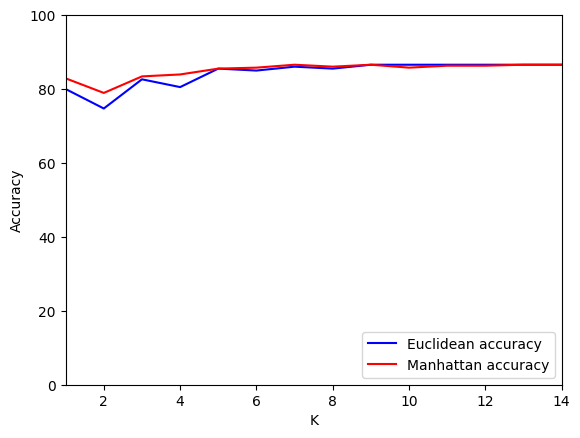

In [232]:
knn = KNN_Graph(1, euclidean_distance)
knn.fit(hepatitis_training, hepatitis_training[:, 0])

hepatitis_k_trials_euclidean = np.zeros(14)
hepatitis_k_trials_manhattan = np.zeros(14)

for i in range(20):
    knn.dist_fn = euclidean_distance
    hepatitis_k_trials_euclidean += knn.k_trial(hepatitis_validation[:, 1:], hepatitis_validation[:, 0], 15)
    knn.dist_fn = manhattan_distance
    hepatitis_k_trials_manhattan += knn.k_trial(hepatitis_validation[:, 1:], hepatitis_validation[:, 0], 15)
    shuffle()

hepatitis_k_trials_euclidean /= 20
hepatitis_k_trials_manhattan /= 20

plot(range(1, 15), [hepatitis_k_trials_euclidean, hepatitis_k_trials_manhattan], 'K', ['Euclidean accuracy', 'Manhattan accuracy'])

#### Different values of maximum depth in DT

Similarly, we are interested in seeing how changing the value of `max_depth` can affect the prediction accuracy of DT.

We perform our test 20 times per value of `max_depth` on the hepatitis data set, and plot the average results.

We perform this experiment for three different cost functions: `gini_index`, `misclass_rate`, and `entropy`.

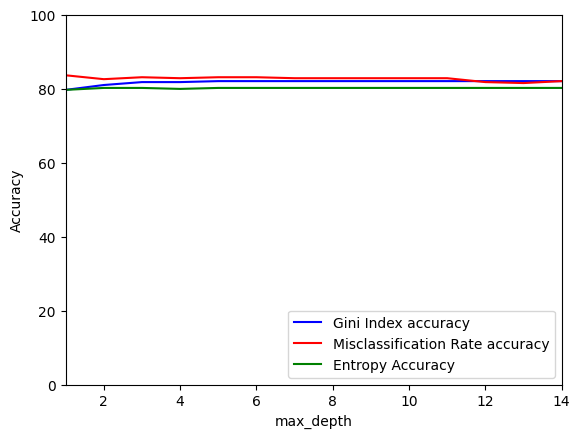

In [233]:
dt = DecisionTree(1)
dt.fit(hepatitis_training, hepatitis_training[:, 0])

hepatitis_max_depth_trials_gini = np.zeros(14)
hepatitis_max_depth_trials_misclass = np.zeros(14)
hepatitis_max_depth_trials_entropy = np.zeros(14)

for i in range(20):
    dt.cost_fn = gini_index
    hepatitis_max_depth_trials_gini += dt.max_depth_trial(hepatitis_training[:, 1:], hepatitis_training[:, 0], hepatitis_validation[:, 1:], hepatitis_validation[:, 0], 15)
    dt.cost_fn = misclass_rate
    hepatitis_max_depth_trials_misclass += dt.max_depth_trial(hepatitis_training[:, 1:], hepatitis_training[:, 0], hepatitis_validation[:, 1:], hepatitis_validation[:, 0], 15)
    dt.cost_fn = entropy
    hepatitis_max_depth_trials_entropy += dt.max_depth_trial(hepatitis_training[:, 1:], hepatitis_training[:, 0], hepatitis_validation[:, 1:], hepatitis_validation[:, 0], 15)

    shuffle()

hepatitis_max_depth_trials_gini /= 20
hepatitis_max_depth_trials_misclass /= 20
hepatitis_max_depth_trials_entropy /= 20

plot(range(1, 15), [hepatitis_max_depth_trials_gini, hepatitis_max_depth_trials_misclass, hepatitis_max_depth_trials_entropy], 'max_depth', ['Gini Index accuracy', 'Misclassification Rate accuracy', 'Entropy Accuracy'])

#### Decision Boundaries

We start by selecting the two most relevant features using cosine similarity.

Decision boundaries for Diabetes using KNN


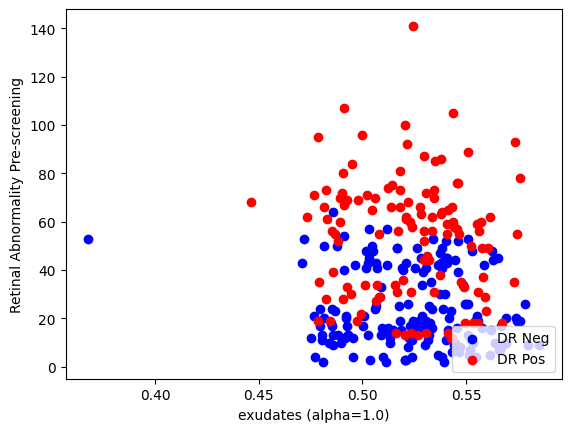


Decision boundaries for Diabetes using DT


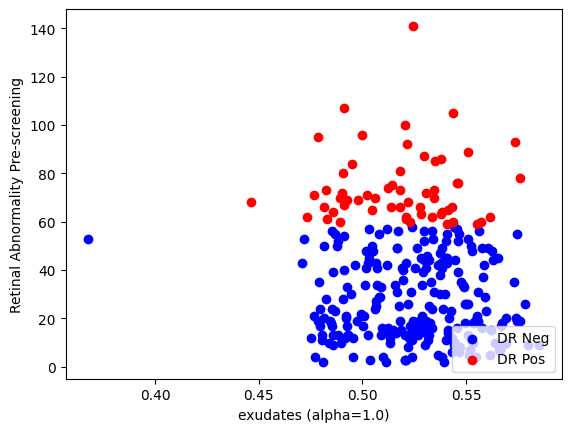

In [234]:
diabetes_features_by_relevance = features_by_relevance(diabetes_clean_data[:, 1:], diabetes_clean_data[:, 0])
diabetes_two_most_relevant_features = np.argsort(diabetes_features_by_relevance)[::-1][:2] + 1
diabetes_two_most_relevant_features_names = np.take(diabetes_feature_names, diabetes_two_most_relevant_features)


diabetes_two_most_relevant_features = np.insert(diabetes_two_most_relevant_features, 0, 0)

diabetes_training_bound = np.take(diabetes_training, diabetes_two_most_relevant_features, axis=1)
diabetes_testing_bound = np.take(diabetes_testing, diabetes_two_most_relevant_features, axis=1)
diabetes_validation_bound = np.take(diabetes_validation, diabetes_two_most_relevant_features, axis=1)

# Decision boundaries plot with KNN
knn = KNN_Graph(3)
knn.fit(diabetes_training_bound, diabetes_training_bound[:, 0])
knn.validate_k(diabetes_validation_bound[:, 1:], diabetes_validation_bound[:, 0], 15)

diabetes_predictions = knn.predict(diabetes_testing_bound[:, 1:])
diabetes_has_dr = []
diabetes_no_dr = []
for i in range(len(diabetes_predictions)):
    if(diabetes_predictions[i] == 0):
        diabetes_no_dr.append(diabetes_testing_bound[i])
    else:
        diabetes_has_dr.append(diabetes_testing_bound[i])
    
diabetes_has_dr = np.array(diabetes_has_dr)
diabetes_no_dr = np.array(diabetes_no_dr)

print("Decision boundaries for Diabetes using KNN")
scatter([diabetes_no_dr[:, 1:], diabetes_has_dr[:, 1:]], ['DR Neg', 'DR Pos'], diabetes_two_most_relevant_features_names)


# Decision boundaries plot with DT
dt = DecisionTree(1)
dt.fit(diabetes_training_bound[:, 1:], diabetes_training_bound[:, 0])
dt.validate_depth(diabetes_training_bound[:, 1:], diabetes_training_bound[:, 0], diabetes_validation_bound[:, 1:], diabetes_validation_bound[:, 0], 15)

diabetes_predictions = dt.predict(diabetes_testing_bound[:, 1:])
diabetes_has_dr = []
diabetes_no_dr = []
for i in range(len(diabetes_predictions)):
    if(diabetes_predictions[i] == 0):
        diabetes_no_dr.append(diabetes_testing_bound[i])
    else:
        diabetes_has_dr.append(diabetes_testing_bound[i])
    
diabetes_has_dr = np.array(diabetes_has_dr)
diabetes_no_dr = np.array(diabetes_no_dr)

print()
print("Decision boundaries for Diabetes using DT")
scatter([diabetes_no_dr[:, 1:], diabetes_has_dr[:, 1:]], ['DR Neg', 'DR Pos'], diabetes_two_most_relevant_features_names)
